In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def first_view(df):
    """
    This function allows to check the variables name, and types.
    Additionaly it allows to check the percentage of null values for each variable

    input: dataframe to be queried
    """
    dtype=df.info()
    null_percentage=(df.isnull().sum() / df.shape[0] * 100)
    null_df = pd.DataFrame({'variable': null_percentage.index, 
                        'null_percentage': null_percentage.values})
    null_df.columns=[['variables', 'null_percentage']]
    return print(dtype, 
                 null_df)

In [3]:
def calculate_percentages(df, x_col, hue_col, order):
    """Calculates percentages for stacked bar chart."""
    total_counts = df.groupby(x_col)[hue_col].count().reindex(order, fill_value=0) #Reindex to ensure correct order and 0 fill
    grouped_counts = df.groupby([x_col, hue_col]).size().unstack(fill_value=0).reindex(order, fill_value=0) #Reindex to ensure correct order and 0 fill
    percentages = np.round((grouped_counts.T / total_counts).T * 100,2)
    return percentages

In [4]:
len(pd.read_csv('database/nonvoters_data.csv', nrows=1).columns)

119

In [5]:
data=pd.read_csv('database/nonvoters_data.csv',usecols=
                 ('ppage', 'educ', 'race', 'gender','income_cat', 
                  'voter_category'))

In [6]:
data.head()

,ppage,educ,race,gender,income_cat,voter_category
0,73,College,White,Female,$75-125k,always
1,90,College,White,Female,$125k or more,always
2,53,College,White,Male,$125k or more,sporadic
3,58,Some college,Black,Female,$40-75k,sporadic
4,81,High school or less,White,Male,$40-75k,always


In [7]:
first_view(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5836 entries, 0 to 5835
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ppage           5836 non-null   int64 
 1   educ            5836 non-null   object
 2   race            5836 non-null   object
 3   gender          5836 non-null   object
 4   income_cat      5836 non-null   object
 5   voter_category  5836 non-null   object
dtypes: int64(1), object(5)
memory usage: 273.7+ KB
None         variables null_percentage
0           ppage             0.0
1            educ             0.0
2            race             0.0
3          gender             0.0
4      income_cat             0.0
5  voter_category             0.0


## Understanding the Data ##

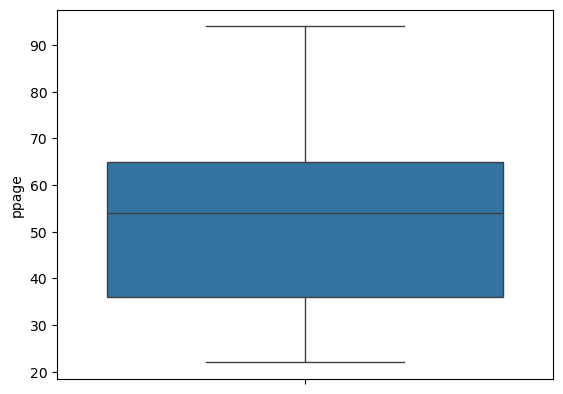

In [8]:
sns.boxplot(data=data, y='ppage');

In [9]:
data.ppage.describe()

count    5836.000000
mean       51.693797
std        17.071561
min        22.000000
25%        36.000000
50%        54.000000
75%        65.000000
max        94.000000
Name: ppage, dtype: float64

75% of the voters are until 65 years, so the marjority are young adults and adults.

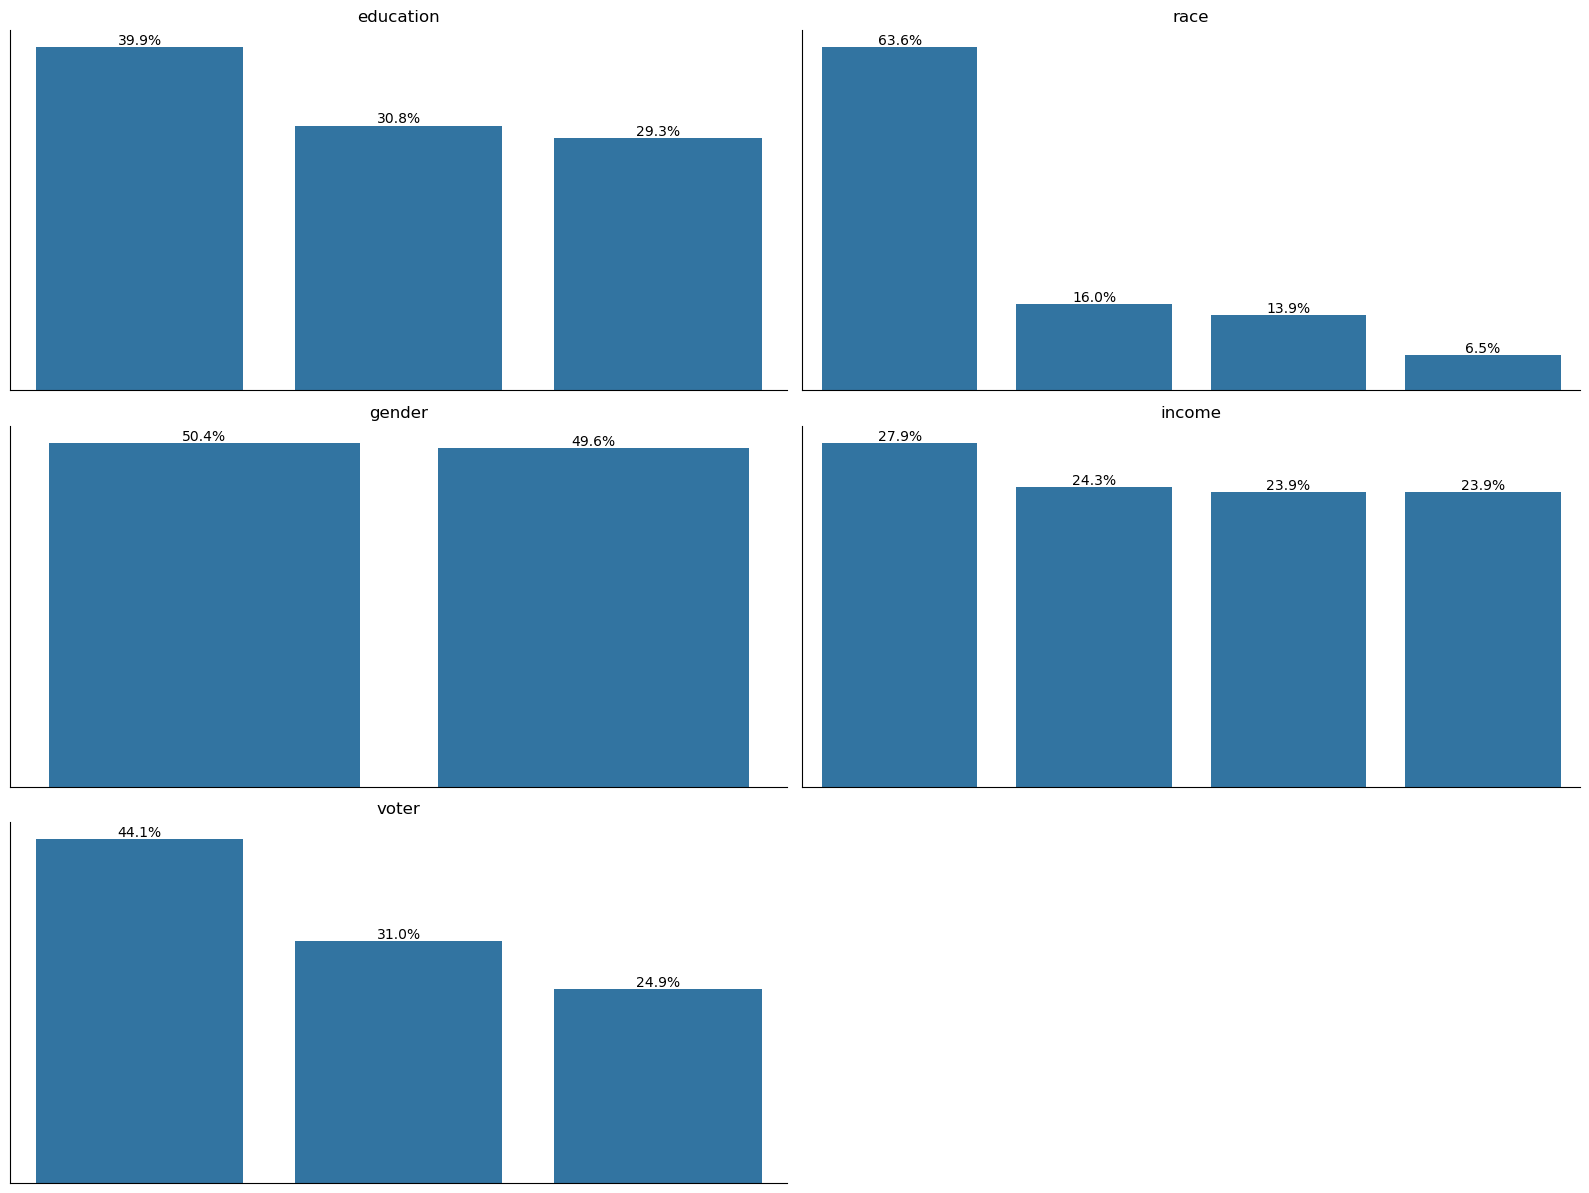

In [10]:
columns_names=data.columns[1:]
num_plots=len(columns_names)
rows=(num_plots+3)//2
plot_name=['education', 'race', 'gender', 'income', 'voter']

fig, axes = plt.subplots(rows, 2, figsize=(16, 4 * rows)) # Add hspace
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, col in enumerate(columns_names):
    df = data[col] #extract column data.
    ax=sns.countplot(x=df, 
                  ax=axes[i],
                 order=df.value_counts().index)#plot the data in the current axis.
    axes[i].set_title(plot_name[i])  # Set title for each subplot
    ax.set_xlabel('') 
    ax.set_ylabel('')     
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine()

    total = len(df) #calculate the total count of the column.
    
    for p in ax.patches:
        height = p.get_height()
        percentage = '{:.1f}%'.format(100 * height / total) #calculate percentage.
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')       

if num_plots < rows * 2:
    for j in range(num_plots, rows * 2):
        fig.delaxes(axes[j])

        
plt.tight_layout()


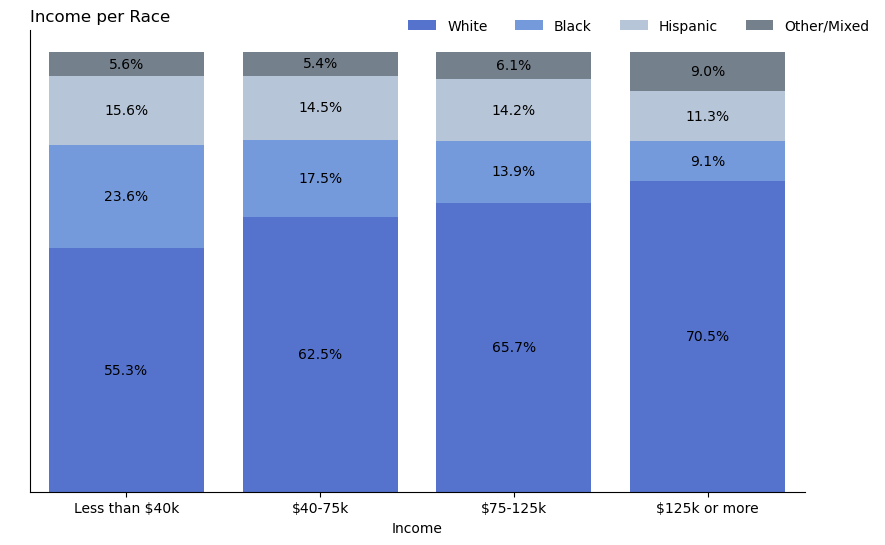

In [11]:
order=['Less than $40k','$40-75k','$75-125k','$125k or more']
percentages=calculate_percentages(data, 'income_cat', 'race', order)
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed

bottom = None #Initialize for stacking
for hue_value, color in zip(['White','Black','Hispanic', 'Other/Mixed'], 
                            ['royalblue', 'cornflowerblue','lightsteelblue', 'slategrey']):
    sns.barplot(x=percentages.index, y=percentages[hue_value], 
                color=color, ax=ax, label=hue_value, bottom=bottom)
    if bottom is None:
        bottom = percentages[hue_value]
    else:
        bottom += percentages[hue_value]

# 3. Add percentage labels above the stacked bars:
for p in ax.patches:
    height = p.get_height()
    if height > 0: #Avoid labels for 0 height bars.
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + height / 2  # Center vertically within the stack
        percentage = height #Height is already the percentage
        ax.text(x, y, f'{percentage:.1f}%', ha='center', va='center', color='black')  # Adjust color as needed

sns.despine()
plt.xlabel("Income") #Optional label
plt.ylabel(" ") #Optional label
plt.yticks(ticks=[])
plt.title("Income per Race", loc='left')
plt.legend(frameon=False, ncol=len(
    data['race'].unique()),bbox_to_anchor=(1.1, 1.05)); #Show legend if needed

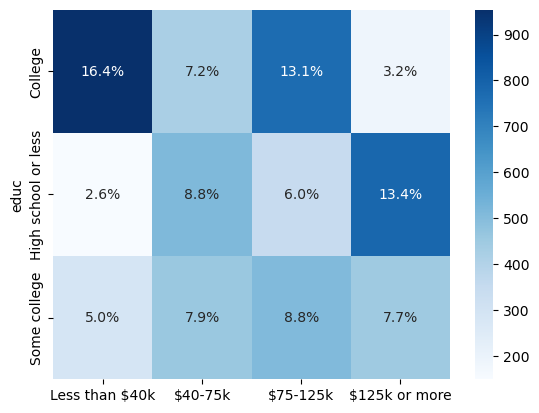

In [12]:
cross_tab=pd.crosstab(data['educ'],data['income_cat'])
cross_order_column=['Less than $40k','$40-75k','$75-125k','$125k or more']
cross_tab.columns=cross_order_column

overall_total = cross_tab.values.sum()
overall_percentages = np.round((cross_tab / overall_total) * 100,2)

annotations = overall_percentages.round(1).astype(str) + '%'
sns.heatmap(cross_tab, annot=annotations, fmt='', cmap='Blues');